In [74]:
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lstm, time #helper libraries
import math

In [104]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(1))
df.head()

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,0.027272
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,0.045895
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,0.080018
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,0.079619


In [105]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[1:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[1:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

Day Model

In [106]:
# Step 2 Build Model
model1 = Sequential()

model1.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model1.add(Dropout(0.4))

model1.add(LSTM(
    100,
    return_sequences=False))
model1.add(Dropout(0.4))

model1.add(Dense(
    output_dim=1))
model1.add(Activation('linear'))

start = time.time()
model1.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.03326678276062012


In [107]:
model1.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

Train on 6907 samples, validate on 364 samples
Epoch 1/10
6907/6907 [==============================] - 19s 3ms/step - loss: 0.5149 - val_loss: 0.4130
Epoch 2/10
6907/6907 [==============================] - 16s 2ms/step - loss: 0.4160 - val_loss: 0.2815
Epoch 3/10
6907/6907 [==============================] - 14s 2ms/step - loss: 0.2867 - val_loss: 0.0386
Epoch 4/10
6907/6907 [==============================] - 15s 2ms/step - loss: 0.0447 - val_loss: 18.7319
Epoch 5/10
6907/6907 [==============================] - 13s 2ms/step - loss: 18.9150 - val_loss: 0.1039
Epoch 6/10
6907/6907 [==============================] - 13s 2ms/step - loss: 0.1085 - val_loss: 0.0672
Epoch 7/10
6907/6907 [==============================] - 13s 2ms/step - loss: 0.0724 - val_loss: 0.0380
Epoch 8/10
6907/6907 [==============================] - 13s 2ms/step - loss: 0.0446 - val_loss: 0.0173
Epoch 9/10
6907/6907 [==============================] - 13s 2ms/step - loss: 0.0240 - val_loss: 0.0060
Epoch 10/10
6907/6907 [=

In [108]:

# Step 4 - Plot the predictions!
predictions_returns_day = np.array(lstm.predict_sequences_multiple(model1, x_test, 50, 1)).flatten()




In [123]:
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_day):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_day):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_day = p0 * (np.exp(r0*predictions_returns_day)

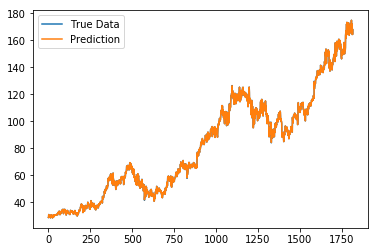

In [124]:
# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_day, label='Prediction')
plt.legend()
plt.show()

Week Model

In [126]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(5))
df.head(10)

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,NaN
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,NaN
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,NaN
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,NaN
5,0.392857,0.392857,0.390625,0.390625,14100800,-0.044742,0.037612,0.013431,0.007022,0.002584,...,0,0,0,0,0,0,0,1,0.017505,0.188062
6,0.397321,0.399554,0.397321,0.397321,13456800,0.016993,0.035557,0.017110,0.007517,0.003140,...,0,0,0,0,0,0,0,1,0.017805,0.177783
7,0.390625,0.390625,0.388393,0.388393,7224000,-0.022722,0.021833,0.014173,0.008683,0.003217,...,0,0,0,0,0,0,0,1,0.017405,0.109166
8,0.390625,0.392857,0.390625,0.390625,7229600,0.005729,0.006975,0.014746,0.009285,0.003354,...,0,0,0,0,0,0,0,1,0.017505,0.034877
9,0.377232,0.377232,0.372768,0.372768,9144800,-0.046778,-0.018304,0.010732,0.006072,0.001775,...,0,0,0,0,0,0,0,1,0.016705,-0.091521


In [128]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[5:math.floor(len(X)*0.8)], X[-len(predictions_returns_week):-1]
y_train, y_test = Y[5:math.floor(len(X)*0.8)], Y[-len(predictions_returns_week):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

In [130]:
# Step 2 Build Model
model2 = Sequential()

model2.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model2.add(Dropout(0.4))

model2.add(LSTM(
    100,
    return_sequences=False))
model2.add(Dropout(0.4))

model2.add(Dense(
    output_dim=1))
model2.add(Activation('linear'))

start = time.time()
model2.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.03291201591491699


In [131]:
model2.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

Train on 6903 samples, validate on 364 samples
Epoch 1/10
6903/6903 [==============================] - 16s 2ms/step - loss: 0.4098 - val_loss: 0.3322
Epoch 2/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.3310 - val_loss: 0.2277
Epoch 3/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.2284 - val_loss: 0.0494
Epoch 4/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.0539 - val_loss: 8.3240
Epoch 5/10
6903/6903 [==============================] - 14s 2ms/step - loss: 8.3699 - val_loss: 0.1079
Epoch 6/10
6903/6903 [==============================] - 15s 2ms/step - loss: 0.1110 - val_loss: 0.1020
Epoch 7/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.1048 - val_loss: 0.0960
Epoch 8/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.0985 - val_loss: 0.0898
Epoch 9/10
6903/6903 [==============================] - 13s 2ms/step - loss: 0.0928 - val_loss: 0.0837
Epoch 10/10
6903/6903 [===

In [132]:
predictions_returns_week = np.array(lstm.predict_sequences_multiple(model2, x_test, 50, 1)).flatten()

In [134]:
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_week):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_week):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_week = p0 * (np.exp(r0*predictions_returns_week))

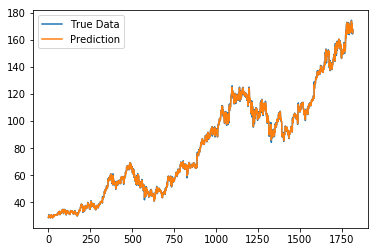

In [135]:
# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_week, label='Prediction')
plt.legend()
plt.show()

2 Weeks

In [136]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(10))
df.head(15)

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,NaN
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,NaN
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,NaN
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,NaN
5,0.392857,0.392857,0.390625,0.390625,14100800,-0.044742,0.037612,0.013431,0.007022,0.002584,...,0,0,0,0,0,0,0,1,0.017505,NaN
6,0.397321,0.399554,0.397321,0.397321,13456800,0.016993,0.035557,0.017110,0.007517,0.003140,...,0,0,0,0,0,0,0,1,0.017805,NaN
7,0.390625,0.390625,0.388393,0.388393,7224000,-0.022722,0.021833,0.014173,0.008683,0.003217,...,0,0,0,0,0,0,0,1,0.017405,NaN
8,0.390625,0.392857,0.390625,0.390625,7229600,0.005729,0.006975,0.014746,0.009285,0.003354,...,0,0,0,0,0,0,0,1,0.017505,NaN
9,0.377232,0.377232,0.372768,0.372768,9144800,-0.046778,-0.018304,0.010732,0.006072,0.001775,...,0,0,0,0,0,0,0,1,0.016705,NaN


In [141]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[10:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[10:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

In [142]:
# Step 2 Build Model
model3 = Sequential()

model3.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model3.add(Dropout(0.4))

model3.add(LSTM(
    100,
    return_sequences=False))
model3.add(Dropout(0.4))

model3.add(Dense(
    output_dim=1))
model3.add(Activation('linear'))

start = time.time()
model3.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.030116796493530273


In [143]:
model3.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

Train on 6898 samples, validate on 364 samples
Epoch 1/10
6898/6898 [==============================] - 16s 2ms/step - loss: 0.3992 - val_loss: 0.3265
Epoch 2/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.3217 - val_loss: 0.2302
Epoch 3/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.2285 - val_loss: 0.0558
Epoch 4/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.0586 - val_loss: 10.0058
Epoch 5/10
6898/6898 [==============================] - 13s 2ms/step - loss: 10.1477 - val_loss: 0.1071
Epoch 6/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.1085 - val_loss: 0.0972
Epoch 7/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.0987 - val_loss: 0.0873
Epoch 8/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.0891 - val_loss: 0.0775
Epoch 9/10
6898/6898 [==============================] - 13s 2ms/step - loss: 0.0796 - val_loss: 0.0677
Epoch 10/10
6898/6898 [=

In [146]:
predictions_returns_2week = np.array(lstm.predict_sequences_multiple(model3, x_test, 50, 1)).flatten()

In [149]:
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_2week):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_2week):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_2week = p0 * (np.exp(r0*predictions_returns_2week))

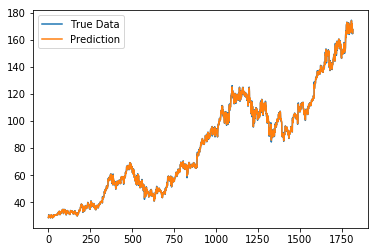

In [150]:
# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_2week, label='Prediction')
plt.legend()
plt.show()

Monthly

In [ ]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(21))
df.head(15)

In [151]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[21:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[21:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

In [152]:
# Step 2 Build Model
model4 = Sequential()

model4.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model4.add(Dropout(0.4))

model4.add(LSTM(
    100,
    return_sequences=False))
model4.add(Dropout(0.4))

model4.add(Dense(
    output_dim=1))
model4.add(Activation('linear'))

start = time.time()
model4.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.0287325382232666


In [164]:
model4.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

Train on 6888 samples, validate on 363 samples
Epoch 1/10
6888/6888 [==============================] - 20s 3ms/step - loss: 0.3855 - val_loss: 0.3058
Epoch 2/10
6888/6888 [==============================] - 14s 2ms/step - loss: 0.3031 - val_loss: 0.1864
Epoch 3/10
6888/6888 [==============================] - 13s 2ms/step - loss: 0.1870 - val_loss: 0.0027
Epoch 4/10
6888/6888 [==============================] - 13s 2ms/step - loss: 0.0102 - val_loss: 2.6180
Epoch 5/10
6888/6888 [==============================] - 13s 2ms/step - loss: 2.6163 - val_loss: 0.1661
Epoch 6/10
6888/6888 [==============================] - 14s 2ms/step - loss: 0.1665 - val_loss: 0.1594
Epoch 7/10
6888/6888 [==============================] - 13s 2ms/step - loss: 0.1604 - val_loss: 0.1524
Epoch 8/10
6888/6888 [==============================] - 13s 2ms/step - loss: 0.1532 - val_loss: 0.1453
Epoch 9/10
6888/6888 [==============================] - 13s 2ms/step - loss: 0.1462 - val_loss: 0.1380
Epoch 10/10
6888/6888 [===

In [167]:
predictions_returns_month = np.array(lstm.predict_sequences_multiple(model4, x_test, 50, 1)).flatten()

In [170]:
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_month):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_month):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_month = p0 * (np.exp(r0*predictions_returns_month))

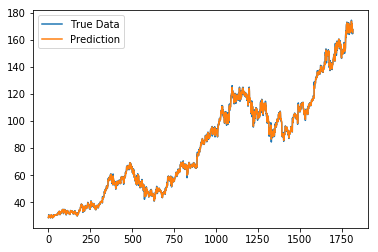

In [171]:
# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_month, label='Prediction')
plt.legend()
plt.show()

Quarterly

In [175]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(42))

In [176]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)

X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[42:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[42:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

In [177]:
# Step 2 Build Model
model5 = Sequential()

model5.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model5.add(Dropout(0.4))

model5.add(LSTM(
    100,
    return_sequences=False))
model5.add(Dropout(0.4))

model5.add(Dense(
    output_dim=1))
model5.add(Activation('linear'))

start = time.time()
model5.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.04007148742675781


In [179]:
model5.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

Train on 6868 samples, validate on 362 samples
Epoch 1/10
6868/6868 [==============================] - 21s 3ms/step - loss: 0.4827 - val_loss: 0.4234
Epoch 2/10
6868/6868 [==============================] - 14s 2ms/step - loss: 0.3945 - val_loss: 0.2981
Epoch 3/10
6868/6868 [==============================] - 13s 2ms/step - loss: 0.2778 - val_loss: 0.0546
Epoch 4/10
6868/6868 [==============================] - 15s 2ms/step - loss: 0.0571 - val_loss: 12.2274
Epoch 5/10
6868/6868 [==============================] - 14s 2ms/step - loss: 12.5610 - val_loss: 0.1253
Epoch 6/10
6868/6868 [==============================] - 13s 2ms/step - loss: 0.1188 - val_loss: 0.0946
Epoch 7/10
6868/6868 [==============================] - 13s 2ms/step - loss: 0.0925 - val_loss: 0.0680
Epoch 8/10
6868/6868 [==============================] - 14s 2ms/step - loss: 0.0689 - val_loss: 0.0460
Epoch 9/10
6868/6868 [==============================] - 15s 2ms/step - loss: 0.0508 - val_loss: 0.0292
Epoch 10/10
6868/6868 [=

In [182]:
predictions_returns_4month = np.array(lstm.predict_sequences_multiple(model5, x_test, 50, 1)).flatten()

In [183]:
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_4month):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_4month):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_4month = p0 * (np.exp(r0*predictions_returns_4month))

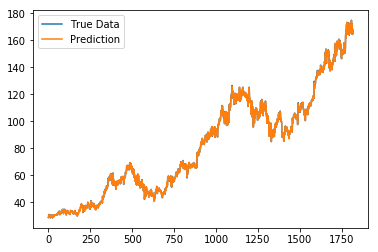

In [184]:
# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_4month, label='Prediction')
plt.legend()
plt.show()

Use these for evaluation metrics

In [185]:
actual_prices
predictions_day
predictions_week
predictions_2week
predictions_month
predictions_4month

array([ 28.68180497,  28.92130435,  30.7093364 , ..., 167.37722648,
       168.12443869, 164.8934284 ])

In [186]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_day = sqrt(mean_squared_error(actual_prices, predictions_day))
rms_week = sqrt(mean_squared_error(actual_prices, predictions_week))
rms_month = sqrt(mean_squared_error(actual_prices, predictions_month))
rms_quarter = sqrt(mean_squared_error(actual_prices, predictions_4month))

In [189]:
print(rms_day)
print(rms_week)
print(rms_month)
print(rms_quarter)

0.08403211820869172
0.38204574734251107
0.49851852355296183
0.11277176180388146


(1817,)

(1817,)